In [2]:
# ----------------------------
# 1. Standard Libraries
# ----------------------------
import math
from itertools import combinations
import pickle

# ----------------------------
# 2. Data Manipulation
# ----------------------------
import pandas as pd
import numpy as np

# ----------------------------
# 3. Visualization
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 4. Preprocessing and Feature Engineering
# ----------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import category_encoders as ce
from transformers.transformers import PeakValueTransformer, IQROutlierRemover

# ----------------------------
# 5. Modeling and Evaluation
# ----------------------------
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             recall_score, precision_score, roc_auc_score)

from sklearn.cluster import KMeans
import statsmodels.api as sm


<br>

In [19]:
df = pd.read_csv('./data/extracted_data/train.csv').drop('id',axis=1)
df[['Previously_Insured','Driving_License','Region_Code']] = df[['Previously_Insured','Driving_License','Region_Code']].astype('str')

# 1. Data Processing

In [13]:
X = df.drop('Response',axis=1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.25)

<br>

## 1.1 Building the Preprocessing Pipeline

<br>

### Scaling with MinMaxScaler

In [6]:
min_max_cols = ['Age','Vintage']

In [7]:
numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())
])

<br>

### One-Hot Encoding

In [8]:
one_hot_cols = ['Gender','Vehicle_Age','Vehicle_Damage']

In [9]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first'))
])

<br>

### Target Enconder

In [10]:
target_encoder_cols = ['Region_Code']

In [11]:
target_encoder_transformer = Pipeline([
    ('targetEncoder',ce.TargetEncoder(smoothing = 0.3))
])

<br>

### Handling Outliers and Secondary Peaks

**IQROutlierRemover:**  
- Clips extreme values in numeric columns based on the interquartile range (IQR) to reduce the impact of outliers.

**PeakValueTransformer:**
- Replaces repeated extreme values that form secondary peaks with a summary statistic (median or mean) to smooth the distributio

In [12]:
out_peak_columns = ['Annual_Premium']

In [13]:
annual_premium_outlier_peak_transformer = Pipeline([
    ('outliers',IQROutlierRemover()),
    ('peak',PeakValueTransformer(peak_value = 2630 , method='median')),
    ('scaler', MinMaxScaler())
])

<br>

### Clustering Column in 3 Groups

In [14]:
kmeans_cols = ['Policy_Sales_Channel']

In [15]:
k = 3


cluster_transformer = Pipeline([
    ('kbins', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')),  
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  
])



<br>

### Final Pipeline

**Preprocessor Pipeline**  
**Smote**  
**Feature Selection**

In [16]:


preprocessor = ColumnTransformer([
    ('out_peak',annual_premium_outlier_peak_transformer,out_peak_columns),
    ('num', numeric_transformer, min_max_cols),
    ('cat', categorical_transformer, one_hot_cols),
    ('target',target_encoder_transformer,target_encoder_cols),
    ('kmeans',cluster_transformer,kmeans_cols)
], remainder='passthrough')

pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100)))
])



In [17]:
with open('./models/pipeline_preprocessor.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

<br>

# 2. Cross-Validation

Decision Tree  
Random Forest   
Logistict Regression  
Gradient Boosting Classifier   
SVM   
KNN


In [18]:
with open('./models/pipeline_preprocessor.pkl', 'rb') as f:
    pipeline_processor = pickle.load(f)

## 2.1 Model Comparison with Cross-Validation

In [38]:
models = {
    'Decision Tree':DecisionTreeClassifier(random_state =42),
    'Random Forest':RandomForestClassifier(random_state =42),
    'Logistic Regression':LogisticRegression(random_state =42),
    'Gradient Boosting':GradientBoostingClassifier(random_state =42),
    'KNN':KNeighborsClassifier()
}

pipelines = {}
for name,model in models.items():
    pipelines[name] = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
        ('classifier', model)
    ])

<br>

## 2.2 Model Evaluation: AUC

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_auc = {}
for name, pipe in pipelines.items():
    scores_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc')

    auc = f'{scores_auc.mean():.3f} ± {scores_auc.std():.3f}'    
    
    scores = [
        auc
    ]
    metrics_auc[name] = scores
    
    
val_auc = pd.DataFrame(metrics_auc,index=['AUC']).T
val_auc

Modelo Decision Tree - AUC médio: 0.601 - Std: 0.000


Modelo Random Forest - AUC médio: 0.818 - Std: 0.002


Modelo Logistic Regression - AUC médio: 0.815 - Std: 0.002


Modelo Gradient Boosting - AUC médio: 0.839 - Std: 0.002


Modelo KNN - AUC médio: 0.784 - Std: 0.003




<br>

### Model Evaluation: Precision, Recall and F1-Score

In [70]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


metrics = {}
for name, pipe in pipelines.items():
    scores_recall = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='recall')
    scores_precision = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='precision')
    scores_f1 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1')

    recall = f'{scores_recall.mean():.3f} ± {scores_recall.std():.3f}'
    precision = f'{scores_precision.mean():.3f} ± {scores_precision.std():.3f}'
    f1 = f'{scores_f1.mean():.3f} ± {scores_f1.std():.3f}'    
    
    scores = [
        recall,
        precision,
        f1
    ]
    metrics[name] = scores
    

val = pd.DataFrame(metrics,index=['Recall','Precision','F1']).T
val    

Modelo Decision Tree - Recall médio: 0.313 - Std: 0.009
Modelo Decision Tree - Precision médio: 0.276 - Std: 0.003
Modelo Decision Tree - F1 médio: 0.293 - Std: 0.005


Modelo Random Forest - Recall médio: 0.327 - Std: 0.005
Modelo Random Forest - Precision médio: 0.309 - Std: 0.004
Modelo Random Forest - F1 médio: 0.318 - Std: 0.003


Modelo Logistic Regression - Recall médio: 0.977 - Std: 0.001
Modelo Logistic Regression - Precision médio: 0.250 - Std: 0.001
Modelo Logistic Regression - F1 médio: 0.398 - Std: 0.001


Modelo Gradient Boosting - Recall médio: 0.854 - Std: 0.009
Modelo Gradient Boosting - Precision médio: 0.290 - Std: 0.002
Modelo Gradient Boosting - F1 médio: 0.433 - Std: 0.002


Modelo KNN - Recall médio: 0.678 - Std: 0.005
Modelo KNN - Precision médio: 0.272 - Std: 0.003
Modelo KNN - F1 médio: 0.388 - Std: 0.003




<br>

### Model Evaluation: Precision and Recall at Top 20%

In [49]:

def precision_recall_at_k(y_true, y_scores, k=0.1):
    """Calcula precision e recall nos top k% com maiores scores"""
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]  

    y_pred_at_k = np.zeros_like(y_true)
    y_pred_at_k[idx] = 1  

    precision = precision_score(y_true, y_pred_at_k)
    recall = recall_score(y_true, y_pred_at_k)
    return precision, recall


In [139]:

k_percent = 0.20  
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics_at_k = {}

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


for name, pipe in pipelines.items():
    
    precisions = []
    recalls = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_skf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_skf, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Treine seu pipeline com SMOTE e o modelo clf
        pipeline = pipelines[name]
        pipeline.fit(X_train_skf, y_train_skf)
        
        # Pegue as probabilidades da classe 1
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        
        # Calcule precision@k e recall@k
        p_k, r_k = precision_recall_at_k(y_val, y_proba, k=k_percent)
        precisions.append(p_k)
        recalls.append(r_k)

    recall_at_k = np.array(recalls)
    precision_at_k = np.array(precisions)

    recall = f'{recall_at_k.mean():.3f} ± {recall_at_k.std():.3f}'
    precision = f'{precision_at_k.mean():.3f} ± {precision_at_k.std():.3f}'

    metrics_at_k[name] = [recall,precision]

val_at_k = pd.DataFrame(metrics_at_k,index=[f'Recall_at_{k_percent*100:.0f}%',f'Precision_at_{k_percent*100:.0f}%']).T
    

In [140]:
val_at_k

,Recall_at_20%,Precision_at_20%
Decision Tree,0.366 ± 0.002,0.224 ± 0.001
Random Forest,0.491 ± 0.007,0.301 ± 0.004
Logistic Regression,0.473 ± 0.002,0.290 ± 0.001
Gradient Boosting,0.533 ± 0.005,0.326 ± 0.003
KNN,0.461 ± 0.007,0.283 ± 0.004


<br>

# 3. Chosen Model: Gradient Boosting

### 3.1 Hyperparameter Tuning

In [22]:
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [1,2,3,4],
}


In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_gb = GridSearchCV(
    estimator=pipelines['Gradient Boosting'],
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_gb.fit(X_train, y_train)

In [79]:
params = {
    x.split('__')[1]:v for x,v in grid_gb.best_params_.items()
}

In [80]:
params

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200}

<br>

### 3.2 Final Model Tuning

In [40]:
with open('./models/pipeline_preprocessor.pkl', 'rb') as f:
    pipeline_processor = pickle.load(f)

In [41]:
params = {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}

In [42]:
pipeline_model = pipeline_processor.steps + [('model', GradientBoostingClassifier(**params, random_state=42))]


pipeline = ImbPipeline(pipeline_model)

In [43]:
print([name for name, step in pipeline_processor.steps])


['preprocess', 'smote', 'feature_selection']


In [44]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('out_peak', ...), ('num', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
with open("./models/pipeline_train.pkl", "wb") as f:
    pickle.dump(pipeline, f)

<br>

### 3.3 Final Evaluation

#### Recall and Precision

In [11]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

recall_train = recall_score(y_train,y_train_pred)
recall_test = recall_score(y_test,y_test_pred)
precision_train = precision_score(y_train,y_train_pred)
precision_test = precision_score(y_test,y_test_pred)

print(f'Train Precision:{precision_train}')
print(f'Test Precision{precision_test}\n')
print(f'Train Recall{recall_train}')
print(f'Test Recall{recall_test}')

Train Precision:0.2774218817999826
Test Precision0.2787996636535632

Train Recall0.9098253025804979
Test Recall0.908545983901353


<br>

#### Recall and Precision at top 20%

In [154]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

k_percent = 0.20  # top 20%
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics_at_k = {}

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

precisions_train = []
recalls_train = []

# ----------------------------
# Treino com K-Fold
# ----------------------------
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_skf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_skf, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Treina no fold
    pipeline.fit(X_train_skf, y_train_skf)
    
    # Predição no fold de validação
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    
    p_k, r_k = precision_recall_at_k(y_val, y_proba, k=k_percent)
    precisions_train.append(p_k)
    recalls_train.append(r_k)

# ----------------------------
# Avaliação final no teste
# ----------------------------
# Treina no treino completo
pipeline.fit(X_train, y_train)

# Predição no teste
y_proba_test = pipeline.predict_proba(X_test)[:, 1]
p_k_test, r_k_test = precision_recall_at_k(y_test, y_proba_test, k=k_percent)

# ----------------------------
# Agregando métricas do treino
# ----------------------------
recall_at_k_train = np.array(recalls_train)
precision_at_k_train = np.array(precisions_train)
recall_train = f'{recall_at_k_train.mean():.3f}'
precision_train = f'{precision_at_k_train.mean():.3f}'

# ----------------------------
# Métricas do teste
# ----------------------------
recall_test = f'{r_k_test:.3f}'
precision_test = f'{p_k_test:.3f}'

# ----------------------------
# DataFrame final
# ----------------------------
metrics_at_k_df = pd.DataFrame(
    [[recall_train, precision_train],
     [recall_test, precision_test]],
    columns=[f'Recall_at_{int(k_percent*100)}%', f'Precision_at_{int(k_percent*100)}%'],
    index=['Train', 'Test']
)

metrics_at_k_df


,Recall_at_20%,Precision_at_20%
Train,0.538,0.330
Test,0.540,0.331


#### Lift Curve

C:\Users\joao\AppData\Local\Temp\ipykernel_11316\192992842.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lift_table = df.groupby("decile").apply(


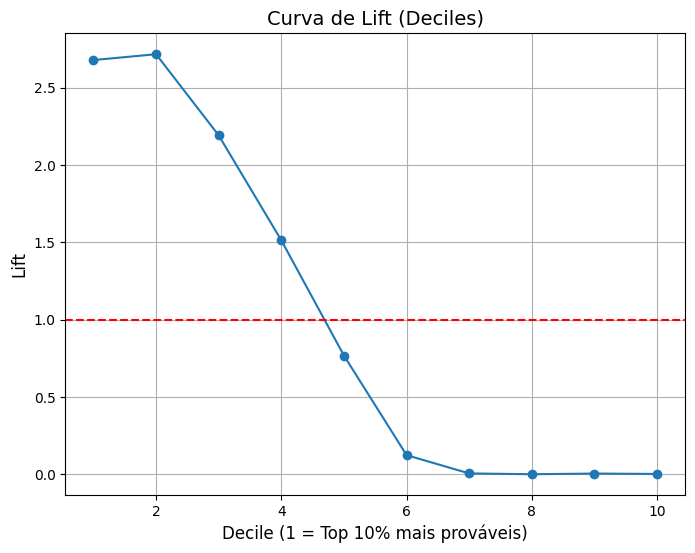

In [89]:
# Get the probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# 5. Create dataframe with labels and probabilities
df = pd.DataFrame({"y_true": y_test, "y_proba": y_pred_proba})

# ORder by probabilitie desc
df = df.sort_values("y_proba", ascending=False).reset_index(drop=True)

# Divide into deciles (10 equal groups)
df["decile"] = pd.qcut(df.index, 10, labels=False)

# 7. Calculate lift
base_rate = df["y_true"].mean()  
lift_table = df.groupby("decile").apply(
    lambda x: x["y_true"].mean() / base_rate
)

# Plot lift curve
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), lift_table.values, marker='o')
plt.axhline(y=1, color='r', linestyle='--')  
plt.title("Curva de Lift (Deciles)", fontsize=14)
plt.xlabel("Decile (1 = Top 10% mais prováveis)", fontsize=12)
plt.ylabel("Lift", fontsize=12)
plt.grid(True)
plt.show()

<br>

# 4. Production

In [49]:
df = pd.read_csv('./extracted_data/train.csv').drop('id',axis=1)
df[['Previously_Insured','Driving_License','Region_Code']] = df[['Previously_Insured','Driving_License','Region_Code']].astype('str')

In [51]:
X_full = df.drop('Response',axis=1)
y_full = df['Response']

In [5]:
with open('./models/pipeline_train.pkl', 'rb') as f:
    pipeline_train = pickle.load(f)

In [59]:
from sklearn.pipeline import Pipeline as SkPipeline

preprocess = pipeline_train.named_steps["preprocess"]
feature_selection = pipeline_train.named_steps["feature_selection"]
model = pipeline_train.named_steps["model"]

# pipeline de produção sem SMOTE
pipeline_prod_full = SkPipeline([
    ("preprocess", preprocess),            # reutilizando o preprocess
    ("feature_selection", feature_selection),  # reutilizando feature_selection
    ("model", model)                       # reutilizando modelo
])



# Treina de novo com todo o dataset
pipeline_prod_full.fit(X_full, y_full)



,steps,"[('preprocess', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('out_peak', ...), ('num', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
with open("./models/pipeline_prod.pkl", "wb") as f:
    pickle.dump(pipeline_prod_full, f)